In [2]:
import torch
import json
import os
import numpy as np
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
from pdf2image import convert_from_path
import tempfile
from pytesseract import Output
import cv2
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_trf
import tensorflow as tf
import pandas as pd
from subprocess import call
import subprocess
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torch.utils.data import DataLoader, Dataset
import uuid

nlp = spacy.load("en_core_web_trf")


def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent


In [3]:
image_from_path = convert_from_path('./test_form.pdf')
for page in image_from_path:
    page.save('test_form.jpg', 'JPEG')
    break

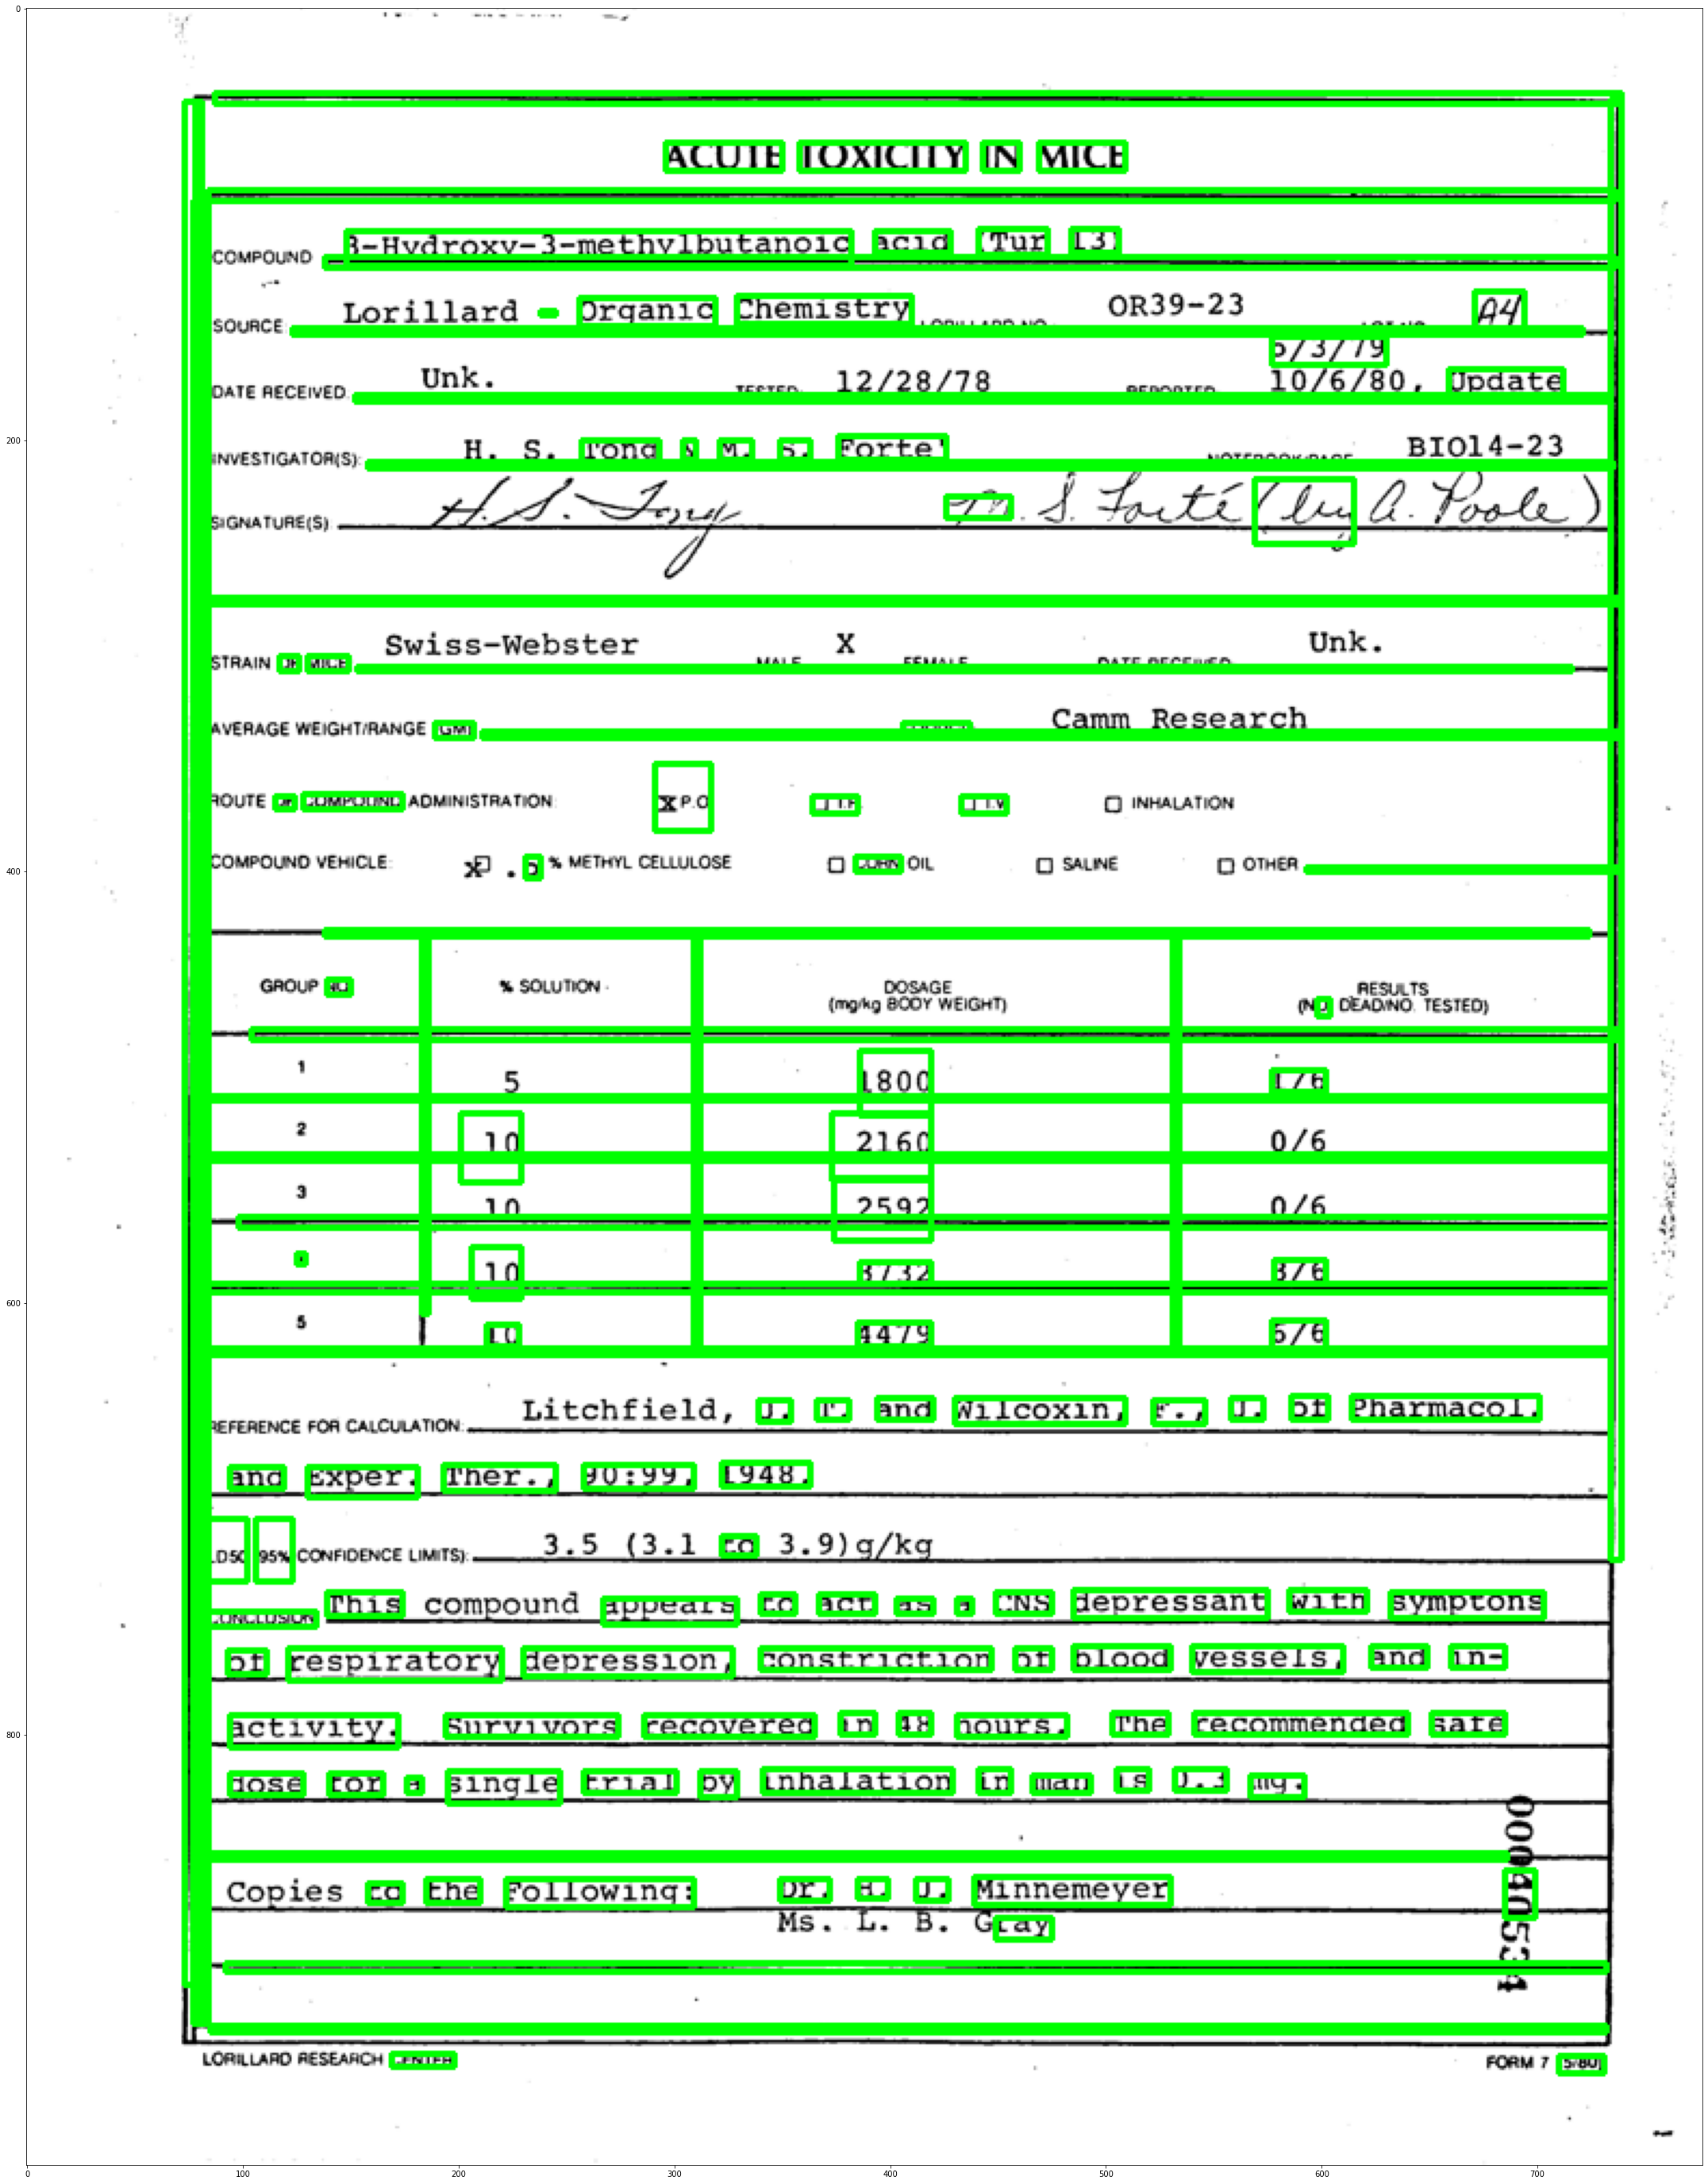

In [4]:
img = cv2.imread("./noisy_documents_dataset/training_data/images/00040534.png")
results = pytesseract.image_to_data(img, output_type=Output.DICT)
for i in range(0, len(results["text"])):
	# extract the bounding box coordinates of the text region from
	# the current result
    x = results["left"][i]
    y = results["top"][i]
    w = results["width"][i]
    h = results["height"][i]
	# extract the OCR text itself along with the confidence of the
	# text localization
    text = results["text"][i]
    conf = int(results["conf"][i])
    if conf > 50:
        text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        #cv2.putText(img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,1.2, (0, 0, 255), 3)


plt.figure(figsize=(50 , 50))
plt.imshow(img)
plt.show()


In [5]:
img = cv2.imread('test_form.jpg')
results = pytesseract.image_to_string(img , output_type=Output.STRING)
doc = nlp(results)
print([(X.text, X.label_) for X in doc.ents])



[('NSD/FARA Registration Unit', 'ORG'), ('04/26/2018 2:21:06 PM', 'DATE'), ('1124-0008', 'CARDINAL'), ('May 31,2020', 'DATE'), ('US', 'GPE'), ('Department of Justice', 'ORG'), ('Washington', 'GPE'), ('20530', 'CARDINAL'), ('the Foreign Agents Registration Act of', 'LAW'), ('the Foreign Agents Registration Act', 'LAW'), ('1938', 'DATE'), ('22 U.S.C. § 61 ler seg', 'LAW'), ('Act', 'LAW'), ('Section 8', 'LAW'), ('the posted business hours', 'TIME'), ('the\nRegistration Unit', 'ORG'), ('Washington', 'GPE'), ('DC', 'GPE'), ("the Registration Unit's", 'ORG'), ('One', 'CARDINAL'), ('State', 'ORG'), ('Congress', 'ORG'), ('Section 6(c)', 'LAW'), ('Congress', 'ORG'), ('.429 hours', 'TIME'), ('Nationa!', 'ORG'), ('U.S. Department of\n', 'ORG'), ('Washington', 'GPE'), ('DC', 'GPE'), ('20530', 'CARDINAL'), ('the Office of Information and Regulatory Affairs', 'ORG'), ('Office of Management and Budget', 'ORG'), ('Washington', 'GPE'), ('Providence', 'GPE'), ('RI', 'GPE'), ('2', 'CARDINAL'), ('Peter Al

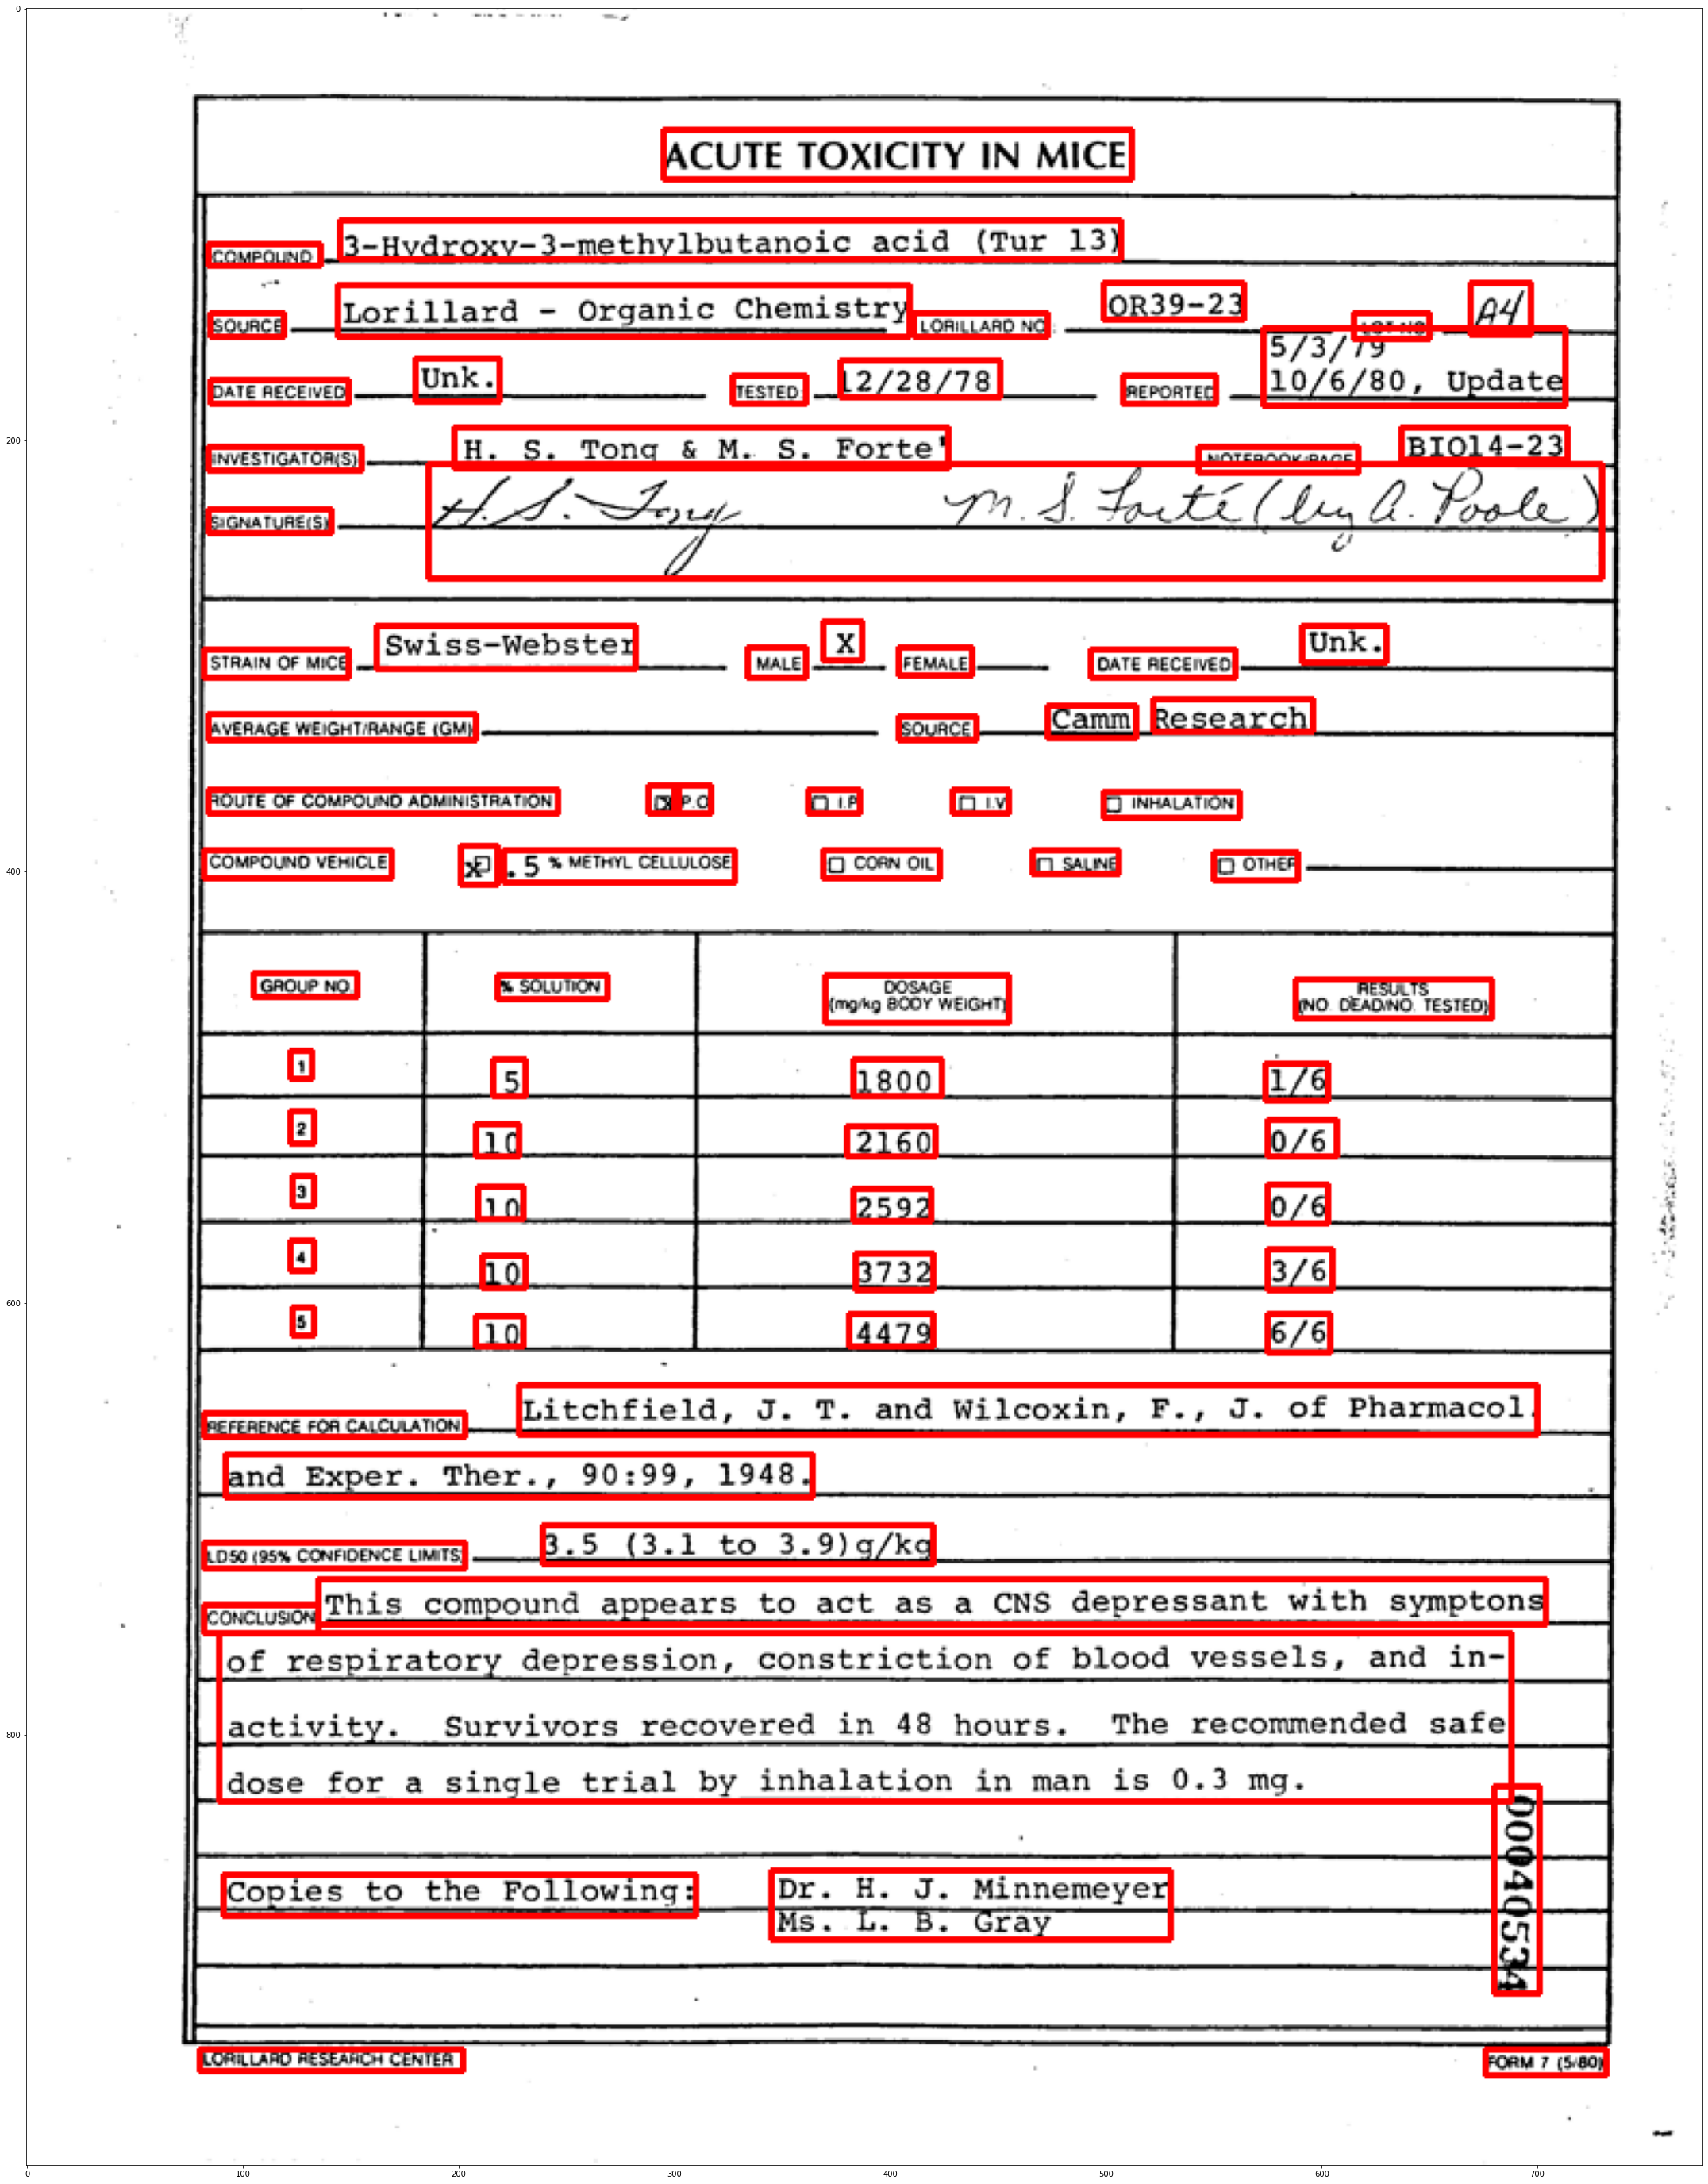

In [6]:
test_img = cv2.imread("./noisy_documents_dataset/training_data/images/00040534.png")
test_json_file = open("./noisy_documents_dataset/training_data/annotations/00040534.json")
test_file_dict = json.load(test_json_file)
for values in test_file_dict["form"]:
    box = values["box"]
    cv2.rectangle(test_img , (box[0] , box[1]) , (box[2] , box[3]) , (255 , 0 , 0) , 2)


    
plt.figure(figsize=(50 , 50))
plt.imshow(test_img)
plt.show()



In [7]:
def combine_two_boxes(box1: [int] , box2:[int]) -> [int]:
    x1_left = box1[0]
    x1_right = box1[2]
    y1_top = box1[1]
    y1_bottom = box1[3]
    x2_left = box2[0]
    x2_right = box2[2]
    y2_top = box2[1]
    y2_bottom = box2[3]
    x_new_left = min((x1_left , x2_left))
    x_new_right = max((x1_right , x2_right))
    y_new_bottom = max((y1_bottom , y2_bottom))
    y_new_top = min((y1_top , y2_top))
    return [x_new_left , y_new_top , x_new_right , y_new_bottom]


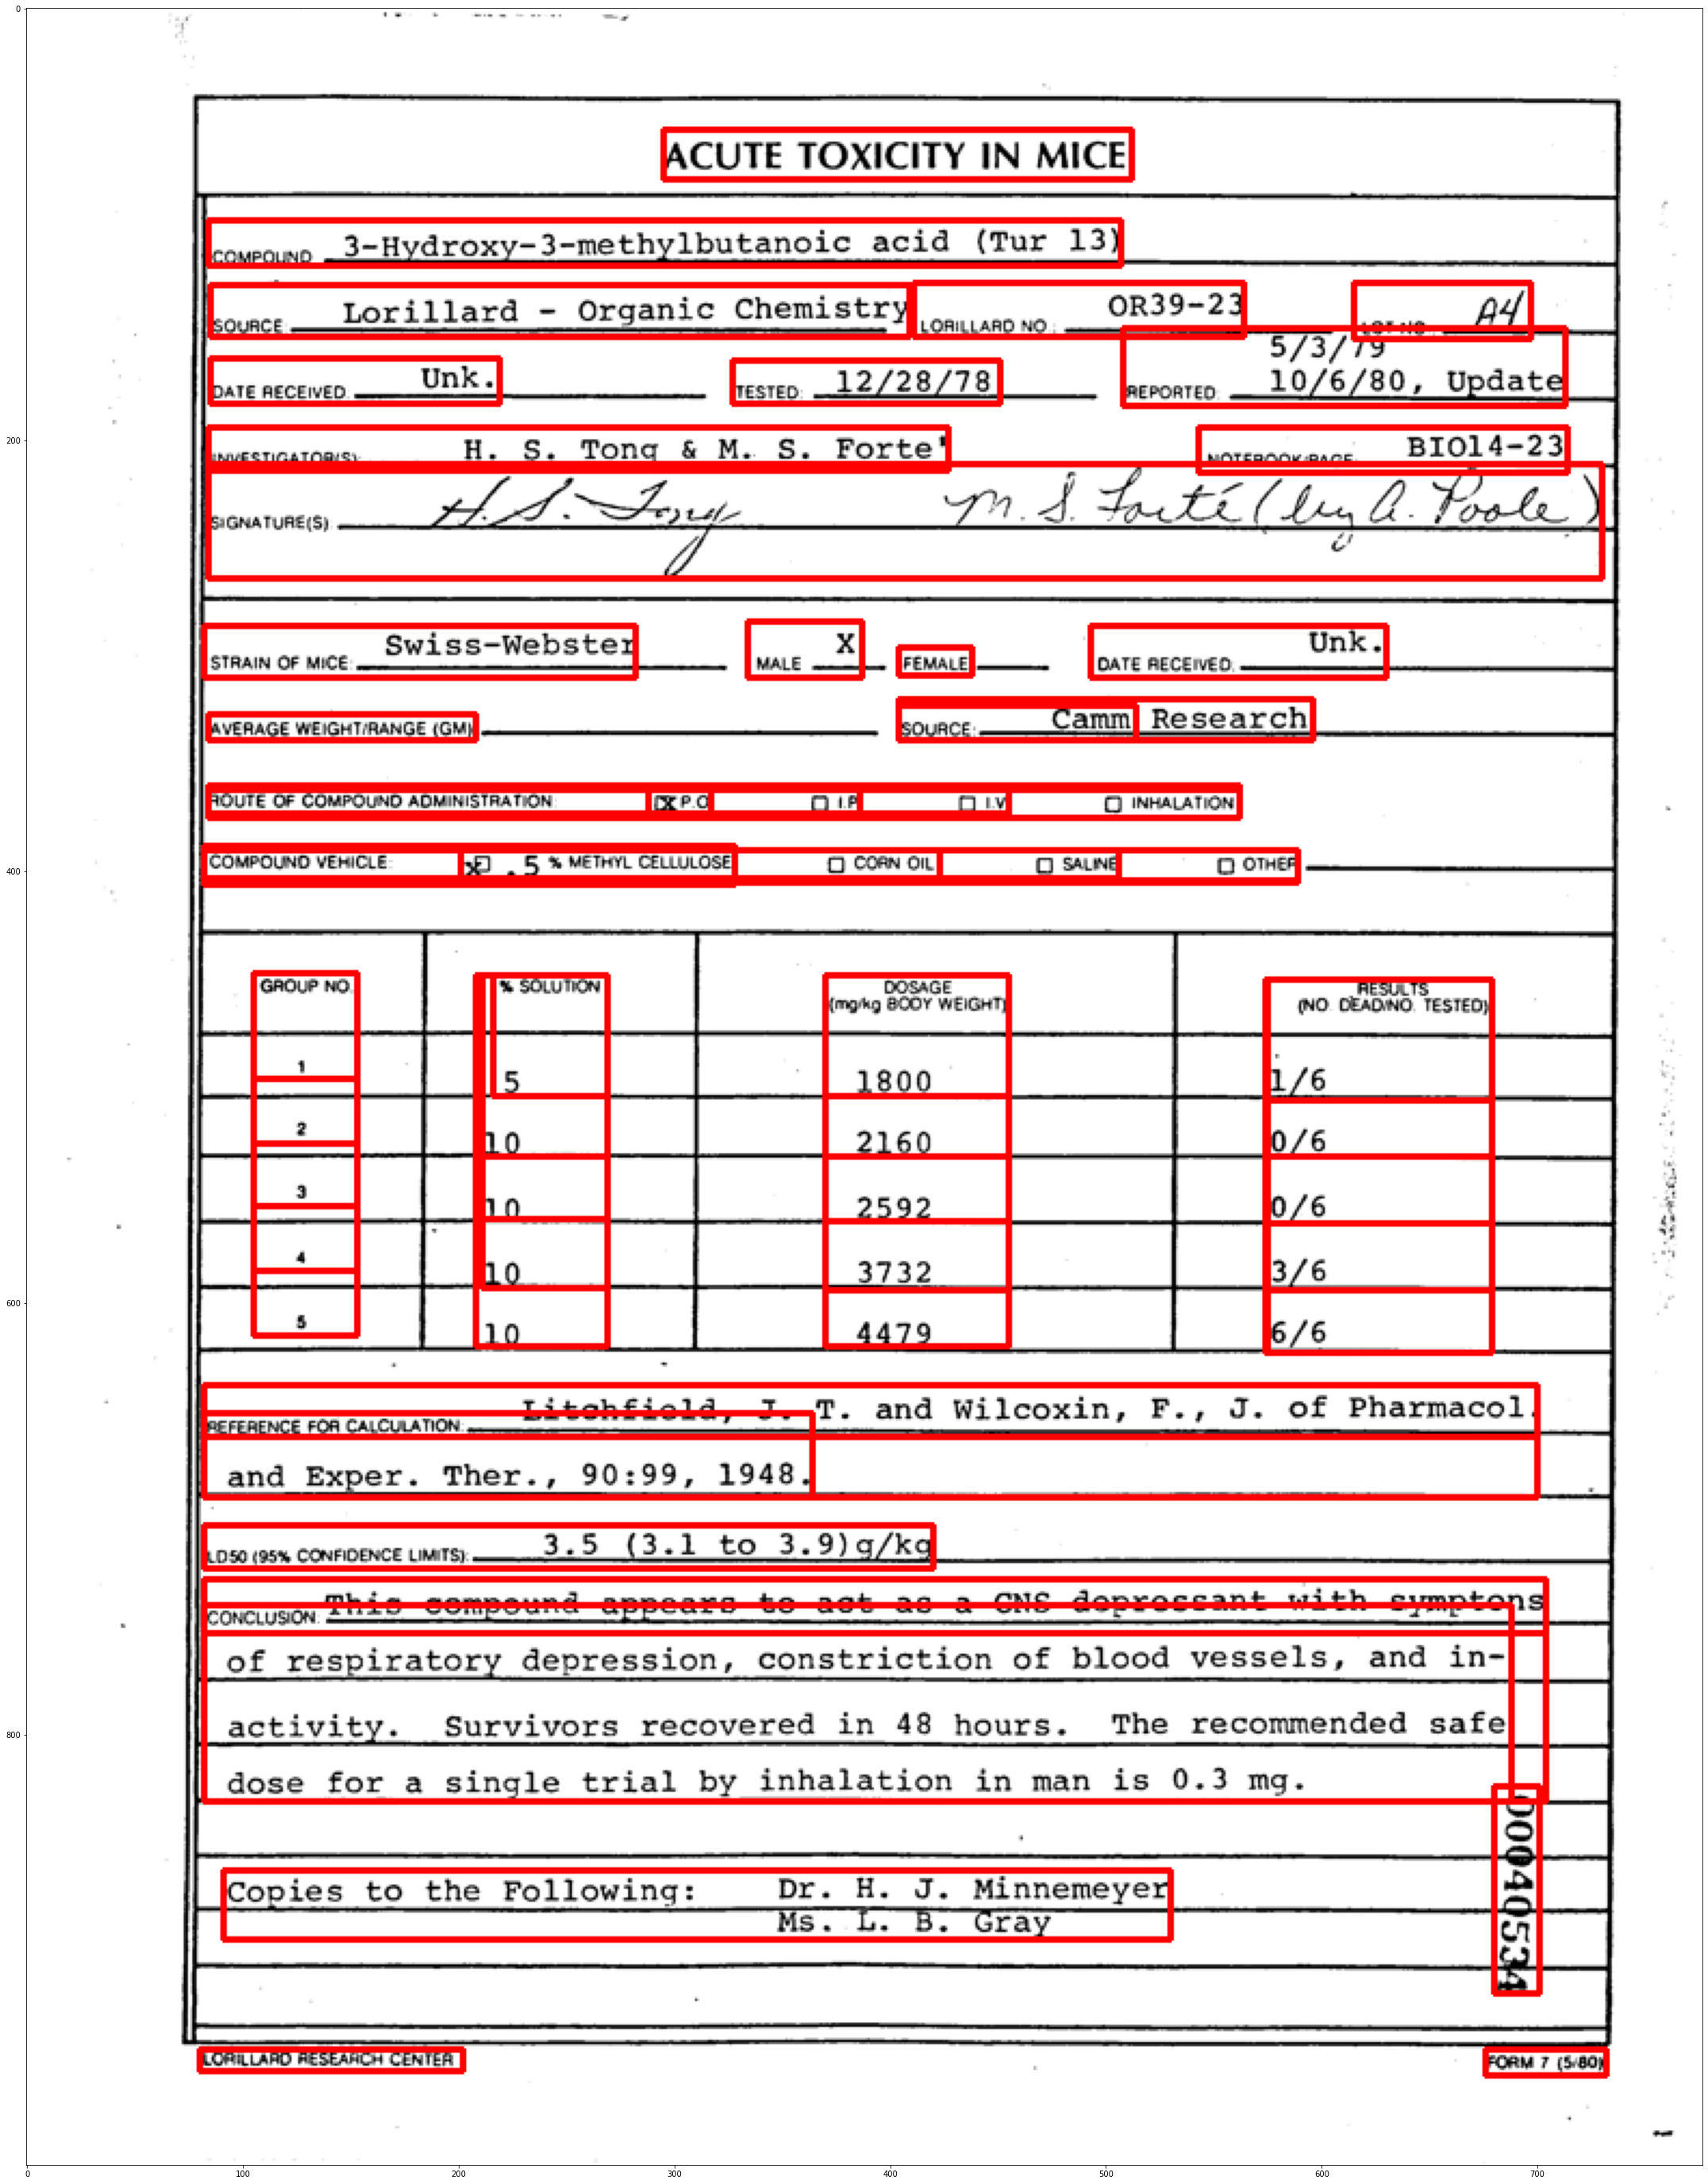

In [8]:
test_combined_img = cv2.imread("./noisy_documents_dataset/training_data/images/00040534.png")
test_combined_json = open("./noisy_documents_dataset/training_data/annotations/00040534.json")
test_combined_dict = json.load(test_combined_json)
already_combined_id = []
counter = 0
form_dict_list = test_combined_dict["form"]
while(len(already_combined_id) < len(form_dict_list)):
    first_bound_dict = form_dict_list[counter]
    curr_box = form_dict_list[counter]["box"]
    curr_box_link = form_dict_list[counter]['linking']
    for links in curr_box_link:
        for link in links:
            link_box = form_dict_list[link]["box"]
            curr_box = combine_two_boxes(link_box , curr_box)

    cv2.rectangle(test_combined_img, (curr_box[0] , curr_box[1]) , (curr_box[2] , curr_box[3]) , (255 , 0 , 0) , 2)
    already_combined_id.append(counter)
    counter += 1

plt.figure(figsize=(50 , 50))
plt.imshow(test_combined_img)
plt.show()

In [9]:
def get_masked(image , annotation):
    already_combined_id = []
    counter = 0
    form_dict_list = annotation["form"]
    while(len(already_combined_id) < len(form_dict_list)):
        first_bound_dict = form_dict_list[counter]
        curr_box = form_dict_list[counter]["box"]
        curr_box_link = form_dict_list[counter]['linking']
        for links in curr_box_link:
            for link in links:
                link_box = form_dict_list[link]["box"]
                curr_box = combine_two_boxes(link_box , curr_box)

        cv2.rectangle(image, (curr_box[0] , curr_box[1]) , (curr_box[2] , curr_box[3]) , (255 , 0 , 0) , 2)
        already_combined_id.append(counter)
        counter += 1
    return image





In [10]:
def generate_masked_training_images():
    image_path = "./noisy_documents_dataset/training_data/images/"
    annotation_path = "./noisy_documents_dataset/training_data/annotations/"
    outPath = "./noisy_documents_dataset/training_data/masked_images/"
    for images in os.listdir(image_path):
        image_file = image_path+images
        file_name = images.strip(".png") + ".json"
        annotation_file = annotation_path + file_name
        json_dict = json.load(open(annotation_file))
        image = cv2.imread(image_file)
        new_image = get_masked(image , json_dict)
        new_image_name = outPath+images
        cv2.imwrite(new_image_name, new_image)

In [11]:
def create_csv_training():
    image_path = "./noisy_documents_dataset/training_data/images/"
    annotation_path = "./noisy_documents_dataset/training_data/annotations/"
    outPath = "./noisy_documents_dataset/training_data/masked_images/"
    id_list = []
    image_list = []
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    label = []
    counter = uuid.uuid4().__str__()
    for images in os.listdir(image_path):
        image_file = image_path+images
        file_name_id = images.strip(".png")
        file_name = images.strip(".png") + ".json"
        annotation_file = annotation_path + file_name
        json_dict = json.load(open(annotation_file))
        box_list = json_dict["form"]
        for i in box_list:
            id_list.append(file_name_id)
            x_top = i["box"][0]
            y_top = i["box"][1]
            x_bottom = i["box"][2]
            y_bottom = i["box"][3]
            box_label = i["label"]
            image_list.append(image_file)
            x1.append(x_top)
            y1.append(y_top)
            x2.append(x_bottom)
            y2.append(y_bottom)
            label.append(box_label)
        counter = uuid.uuid4().__str__()
    df = pd.DataFrame(list(zip(id_list,image_list , x1 , y1 , x2 , y2 , label)))
    return df


In [12]:
def create_csv_testing():
    image_path = "./noisy_documents_dataset/testing_data/images/"
    annotation_path = "./noisy_documents_dataset/testing_data/annotations/"
    outPath = "./noisy_documents_dataset/testing_data/masked_images/"
    id_list = []
    image_list = []
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    label = []
    counter = uuid.uuid4().__str__()
    for images in os.listdir(image_path):
        image_file = image_path+images
        file_name_id = images.strip(".png")
        file_name = images.strip(".png") + ".json"
        annotation_file = annotation_path + file_name
        json_dict = json.load(open(annotation_file))
        box_list = json_dict["form"]
        for i in box_list:
            id_list.append(file_name_id)
            x_top = i["box"][0]
            y_top = i["box"][1]
            x_bottom = i["box"][2]
            y_bottom = i["box"][3]
            box_label = i["label"]
            image_list.append(image_file)
            x1.append(x_top)
            y1.append(y_top)
            x2.append(x_bottom)
            y2.append(y_bottom)
            label.append(box_label)
        counter = uuid.uuid4().__str__()
    df = pd.DataFrame(list(zip(id_list,image_list , x1 , y1 , x2 , y2 , label)))
    return df

In [13]:
def generat_save_training_csv():
    dataframe = create_csv_training()
    dataframe.to_csv("./noisy_documents_dataset/training_data/data.csv", index=False , header=["image_id","image_path" , "x1" , "y1" , "x2" , "y2" , "label"])


In [14]:
def generat_save_testing_csv():
    dataframe = create_csv_testing()
    dataframe.to_csv("./noisy_documents_dataset/testing_data/data.csv" , index=False , header=["image_id","image_path" , "x1" , "y1" , "x2" , "y2" , "label"])

In [15]:
generat_save_training_csv()
generat_save_testing_csv()

In [16]:
class TrainDataset(Dataset):
    def __init__(self , annotation_file):
        super().__init__()
        self.df = pd.read_csv(annotation_file)
        self.image_ids = self.df["image_id"].unique()
    
    def __getitem__(self , index:int):
        label = ["question", "answer" , "header", "other"]
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        path  = 'noisy_documents_dataset/training_data/images/{0}.png'.format(image_id)
        img = cv2.imread(path , cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0
        boxes = records[['x1', 'y1', 'x2', 'y2']].values
        boxes = torch.as_tensor(boxes , dtype=torch.float32)
        labels = records[['label']].values
        labels = [[label.index(x) for x in j] for j in labels]
        labels = torch.as_tensor(labels , dtype=torch.float32)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        image = torchvision.transforms.ToTensor()(img)
        return image , target
    
    def __len__(self):
        return self.image_ids.shape[0]




In [17]:
train_dataset = TrainDataset('./noisy_documents_dataset/training_data/data.csv')

def collate_fn(batch):
    return tuple(zip(*batch))


train_data_loader = DataLoader(train_dataset , batch_size = 2 , shuffle = True , num_workers = 1 , collate_fn = collate_fn)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')



In [21]:
images, targets = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets =   [{k: v.to(device) for k , v in t.items()} for t in targets]
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
img = images[0].permute(1 , 2 , 0).cpu().numpy()
fig , ax = plt.subplots(1 , 1 , figsize=(12 , 6))
plt.imshow(img)
plt.show()


for box in boxes:
    cv2.rectangle(img , box[0], box[1] , box[2] , box[3] , (255, 0 , 0))

ax.set_axis_off()
ax.imshow(img)


SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-21-ca0b62effac2>, line 16)